In [1]:
from os import listdir
from os.path import isfile, join
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
import codecs
mypath ="/Anaconda/blogs"
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split
from time import time
import sys
import scipy.sparse as sp
import pylab as pl
import cPickle
import sqlite3
import pandas as pd
import matplotlib as plt
%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
#combining Products separated in Database by type
#Operations on data performed using Pandas 
#Sqlite was used as Base database during Scrapping.

def getData(name,ptype):
    print name+" Database for Reviews and Products"
    # Read sqlite query results into a pandas DataFrame
    con = sqlite3.connect("Scrape-Amazon\\amazon\\"+name+".db")
    Product_df = pd.read_sql_query("SELECT * from Amazon", con)
    Product_Reviews_df = pd.read_sql_query("SELECT * from Review",con)
    # verify that result of SQL query is stored in the dataframe
    print name+" Data\n",Product_df.head()
    print name+" Reviews\n",Product_Reviews_df.head()
    
    print "\n Joining Product with Reviews.."
    product = pd.merge(Product_df,Product_Reviews_df,on="pid",how="inner")
    number = product.shape[0]
    ptypeList =[ptype for i in range(0,number)]
    product['Type'] = ptypeList
    con.close()
    return product

listOfProducts = ['Booknew','Comp','Desktop']
names = ['book','electronic','desktop']
prod_df = []
for p in range(0,len(listOfProducts)):
    prod_df.append( getData(listOfProducts[p],names[p]))
    
prods = pd.concat(prod_df)
print prods.head()
print "Droping id_x and id_y cols ..."

prods.drop(['id_x','id_y','path'],axis=1,inplace=True)

Booknew Database for Reviews and Products
Booknew Data
   id         pid                                               name  \
0   1  B00OAMFOF0  Rechargeable Reading Lamp for Bed & Music Stan...   
1   2  1628600543  It Starts With Food: Discover the Whole30 and ...   
2   3  1476746583                        All the Light We Cannot See   
3   4  B0039W9S0E                                   The Book Of Love   
4   5  0996275460  Adult Coloring Books: A Coloring Book for Adul...   

                                                path   price  
0  http://www.amazon.com/Rechargeable-Reading-Mus...  $16.95  
1  http://www.amazon.com/Starts-Food-Discover-Who...  $16.17  
2  http://www.amazon.com/All-Light-We-Cannot-See/...  $16.20  
3  http://www.amazon.com/The-Book-Of-Love/dp/B003...   $9.99  
4  http://www.amazon.com/Adult-Coloring-Books-Fea...  $12.89  
Booknew Reviews
   id             rid              rname         pid  \
0   1  R2LHYLHQSHW2UK     Jackie  Cooper  0996275460   
1   2 

In [4]:
prods.columns = ['Product ID', 'Product Name','Price(Dollar)','Reviewer ID','Reviewer Username','Review','Product Type']


In [5]:
nframe = prods.copy()
nframe[nframe['Price(Dollar)']=='Free']='$0'
nframe['Price(Dollar)'] = nframe['Price(Dollar)'].apply(lambda v:float(v.replace('$','').replace(',','').split('-')[0]) )

print "Saving Filtered and Combined Data to Csv..."
nframe.to_csv('Filtered_Data.csv',sep=',',encoding='utf-8')

Saving Filtered and Combined Data to Csv...


# Data Analysis
### 1. Age Prediction
### 2. Gender Prediction
### 3. Other Analysis

In [6]:
print "Loading Naive Bayes Trained Model for Age Prediction(Sentiment Analysis)"
with open('MultiNB.pkl', 'rb') as fid:
    NB_loaded = cPickle.load(fid)

Loading Naive Bayes Trained Model for Age Prediction(Sentiment Analysis)


In [7]:
print NB_loaded

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)


In [8]:
reviews = nframe['Review'].tolist()

In [9]:
with open('TFIDF_Vectorizer.pkl', 'rb') as fid:
    Vect_loaded = cPickle.load(fid)

In [10]:
Review_Vectorized = Vect_loaded.transform(reviews)

In [11]:
print Review_Vectorized.shape

(6320, 586663)


In [12]:

print("Predicting the outcomes of the testing set")
t0 = time()
pred = NB_loaded.predict(Review_Vectorized)
print("done in %fs" % (time() - t0))
print pred

Predicting the outcomes of the testing set
done in 0.015000s
[2 2 2 ..., 2 2 2]


In [13]:
print "Number of Reviewrs in Age group: 13-17",np.sum(np.array(pred)==1)
print "Number of Reviewrs in Age group: 17-33",np.sum(np.array(pred)==2)
print "Number of Reviewrs in Age group: 33 - ",np.sum(np.array(pred)==3)
pred = np.array(pred)
AgeFrame = pd.DataFrame(data=pred,columns=['Age'])
ages = []
for a in AgeFrame['Age']:
    if a == 1:
        ages.append('13-17') 
    elif a==2:
        ages.append('17-33')
    else:
        ages.append('33-90')
AgeFrame['Ages']=ages   
AgeFrame.head()

Number of Reviewrs in Age group: 13-17 139
Number of Reviewrs in Age group: 17-33 5742
Number of Reviewrs in Age group: 33 -  439


,Age,Ages
0,2,17-33
1,2,17-33
2,2,17-33
3,2,17-33
4,2,17-33


In [14]:
import seaborn as sns
sns.set(style="white")

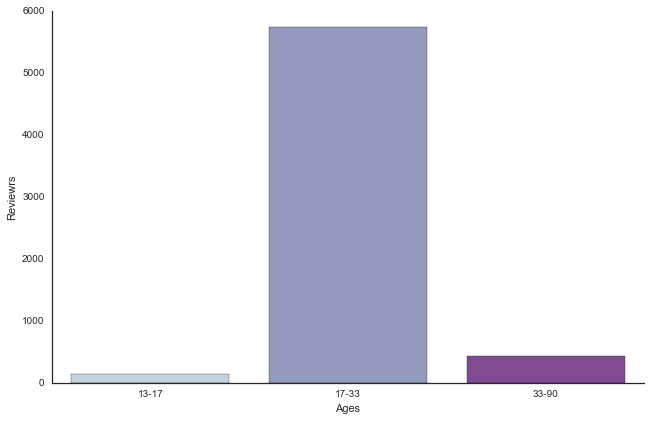

In [15]:
years = ["13-17","17-33","33-90"]
g = sns.factorplot(x="Ages", data=AgeFrame, kind="count",
                   palette="BuPu", size=6, aspect=1.5, order=years)
g.set_xticklabels(step=1)
g.set_ylabels("Reviewrs")
g.savefig('Reviewrs_Age')

In [16]:
print "Loading Naive Bayes trained model for Gender Classification"
with open('MultinomialNB.pkl', 'rb') as fid:
    NB_loaded = cPickle.load(fid)

Loading Naive Bayes trained model for Gender Classification


In [17]:
with open('TFIDF_Age_Vectorizer.pkl', 'rb') as fid:
    Vect_loaded = cPickle.load(fid)

In [18]:
Review_Vectorized = Vect_loaded.transform(reviews)

In [19]:

print("Predicting the outcomes of the testing set")
t0 = time()
Gender = NB_loaded.predict(Review_Vectorized)
print("done in %fs" % (time() - t0))
print Gender


Predicting the outcomes of the testing set
done in 0.012000s
['female' 'male' 'female' ..., 'male' 'male' 'male']


In [20]:
GenderFrame = pd.DataFrame(data=Gender,columns=['Gender'])

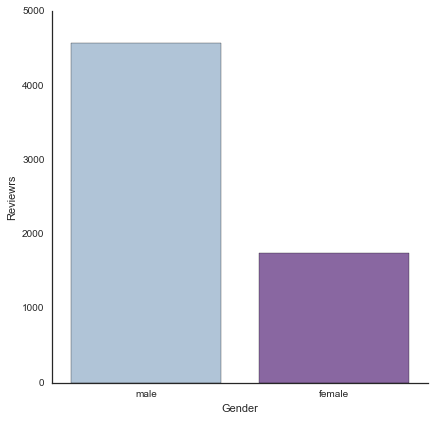

In [21]:
years = ['male','female']
g = sns.factorplot(x="Gender", data=GenderFrame, kind="count",
                   palette="BuPu", size=6, aspect=1, order=years)
g.set_xticklabels(step=1)
g.set_ylabels("Reviewrs")
g.savefig('Reviewrs_Gender')

In [22]:
Combined_dataFrame = pd.DataFrame(data=AgeFrame.join(GenderFrame))
     

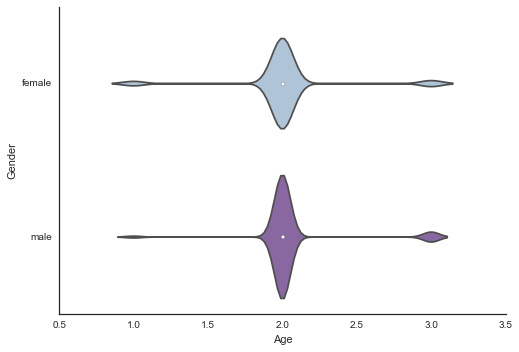

In [23]:
sns.violinplot(Combined_dataFrame['Age'], Combined_dataFrame['Gender'],palette="BuPu", size=8, aspect=2.0) #Variable Plot
sns.despine()


In [24]:
nframe['Gender'] = GenderFrame['Gender']
nframe['Age Group'] = AgeFrame['Ages']


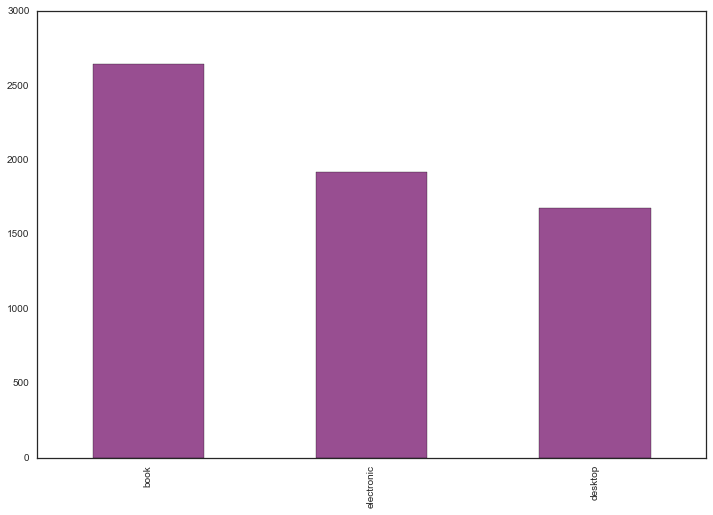

In [25]:
plot = nframe['Product Type'].where(nframe['Product Type']!='$0').value_counts().plot(kind = 'bar',color = '#984e91',figsize=(12,8))

In [29]:
nframe.to_csv("Data.csv",encoding="utf-8")